In [4]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [51]:
def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.plasma)
    plt.show()

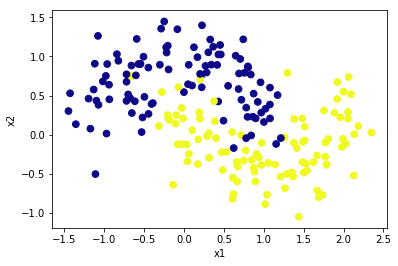

In [52]:
# # generate and visualize Make-Moons dataset
np.random.seed(0)
X, y = datasets.make_moons(200, noise=0.25)
t = np.zeros((len(y), 2))
for i, val in np.ndenumerate(y):
    if val == 0:
        t[i, 0] = 0
        t[i, 1] = 1
    else:
        t[i, 0] = 1
        t[i, 1] = 0
plt.scatter(X[:, 0], X[:, 1], s=45, c=y, cmap=plt.cm.plasma)
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

## Activation Functions

#### Sigmoid:
$$f(x) = \frac{1}{1+e^{-x}}$$

#### TanH:
$$f(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$$

#### ReLu:
$$f(x) =
  \begin{cases}
    0       & \quad \text{for } x < 0 \\
    x  & \quad \text{for } x \geq{0}
  \end{cases}$$
$$\text{OR}$$
$$f(x) = \max{\left( 0, x \right)}$$
  
## The Derivatives of the Activation Functions

#### Sigmoid:
$$\frac{\mathrm d}{\mathrm d x} \left( \frac{1}{1+e^{-x}} \right) = \frac{e^{-x}}{\left( 1+e^{-x} \right)^2}$$

#### TanH:
$$\frac{\mathrm d}{\mathrm d x} \left( \frac{e^x-e^{-x}}{e^x+e^{-x}} \right) = \frac{4e^{2x}}{\left( 1+e^{2x} \right)^2}$$

#### ReLu:
$$\frac{\mathrm d}{\mathrm d x} f(x) =
  \begin{cases}
    0  & \quad \text{if } x < 0 \\
    1  & \quad \text{if } x \geq 0 
  \end{cases}$$

-----

In [28]:
class Neural_Net(object):
    
    def __init__(self, NN_size, actFun_type, reg_lambda=0.0001, seed=10):
        
        self.layers=len(NN_size)
        self.sizes=NN_size
        
        
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda

        self.losses = []
        self.out=[]

        
        np.random.seed(seed)
        self.W=[np.random.randn(x,y) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.b=[np.random.randn(y) for y in self.sizes[1:]]



    def actFun(self, a, non_Linearity):
        '''
        actFun computes the activation functions
        :param a = net input
        :param non_Linearity = Tanh, Sigmoid, or ReLU
        :return: net activation
        '''
        
        if non_Linearity == 'tanh':
            out = (np.exp(a)-np.exp(-a)) / (np.exp(a)+np.exp(-a))
        elif non_Linearity == 'sigmoid':
            out = 1 / (1 + np.exp(-a))
        elif non_Linearity == 'relu':
            out=(a+np.abs(a))/2
        else:
            print("Only three types of activation functions: tanh, sigmoid, and relu. Please try again")
        
        return np.nan_to_num(out)

        


    def diff_actFun(self, a, non_Linearity):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param a= net input
        :param non_Linearity = Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''
        
        if non_Linearity == 'tanh':
            out = 4*np.exp(2*a) / np.square(1 + np.exp(2*a))
        elif non_Linearity == 'sigmoid':
            out = np.exp(-a) / np.square(1 + np.exp(-a))
        elif non_Linearity == 'relu':
            out = 1. * (a > 0)
        else:
            print("Only three types of activation functions: tanh, sigmoid, and relu. Please try again")
        
        return np.nan_to_num(out)
        

    def softmax(self, z):

        exp_sum = np.sum(np.exp(z), 1)
        t = np.tile(exp_sum, [2, 1]).T
        out = np.exp(z)* (1 / t)

        return out

    def ForwardPass(self, X, actFun):
        
        self.out.append(X)
        for w, b in zip(self.W[:-1], self.b[:-1]):
            X=actFun(np.dot(X,w)+b.T)
            self.out.append(X)
         
        
        X= np.dot(X,self.W[self.layers-2])+self.b[self.layers-2].T
        self.probs = self.softmax(X)

        return None

    def calculate_loss(self, t):
        
        
        self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
        a = np.nan_to_num(np.log(self.probs))
        data_loss=np.mean(-np.sum(a*t))
        self.out=[]


        
        return data_loss    
        

    def predict(self, X):
        
        self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
        self.out=[]
        return np.argmax(self.probs, axis=1)

    def backwardPass(self, X, t):
        out = self.out
        
        delta_scores = (self.probs - t)
        dW=[np.zeros((x,y)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.out=[]
        self.ForwardPass(X, lambda x: self.diff_actFun(x, self.actFun_type))
        
        delta = [np.zeros((200, y)) for y in self.sizes]
        delta[self.layers-1]=delta_scores
        
        for i in range(self.layers-1):
            delta[self.layers-2-i]=np.dot(delta[self.layers-1-i],self.W[self.layers-2-i].T)*self.out[self.layers-2-i]
        
        
        for j in range(self.layers-1):
            dW[j]=np.dot(out[j].T, delta[j+1])
            delta[j+1]=np.mean(delta[j+1], axis=0)
        
        db = delta[1:]
        
        self.out=[]
        return dW, db

    def fit_model(self, X, t, epsilon, num_passes=4000, print_loss=True):
        
        for i in range(0, num_passes):
            self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
            dW, db = self.backwardPass(X, t)
            
            if i <2000:
                lbd=10000*self.reg_lambda
            elif i<2500:
                lbd=1000*self.reg_lambda
            elif i<3000:
                lbd=100*self.reg_lambda
            elif i<3500:
                lbd=10*self.reg_lambda
            elif i<4000:
                lbd=0.1*self.reg_lambda
            else :
                lbd=0.001*self.reg_lambda
            
            for j in range(self.layers-1):
                dW[j] += lbd * self.W[j]
                self.W[j] += -epsilon * dW[j]
                self.b[j] += -epsilon * db[j]
            
            if print_loss and i % 200 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(t)))
                result = self.calculate_loss(t)
                self.losses.append(result)
              
        mean=np.mean(self.losses)

        return mean, self.losses

    def visualize_decision_boundary(self, X, y):
        plot_decision_boundary(lambda x: self.predict(x), X, y)

### Play with different network architectures
#### (1) 4 Layers, 2 hidden layers: one has 10 neurons, another has 6 neurons

Loss after iteration 0: 285.370587
Loss after iteration 200: 52.793672
Loss after iteration 400: 48.259029
Loss after iteration 600: 44.786564
Loss after iteration 800: 40.497021
Loss after iteration 1000: 38.441391
Loss after iteration 1200: 36.896104
Loss after iteration 1400: 35.749671
Loss after iteration 1600: 36.772142
Loss after iteration 1800: 41.663627
Loss after iteration 2000: 76.809415
Loss after iteration 2200: 57.535342
Loss after iteration 2400: 48.154695
Loss after iteration 2600: 41.124045
Loss after iteration 2800: 39.260920
Loss after iteration 3000: 39.063417
Loss after iteration 3200: 39.029746
Loss after iteration 3400: 38.844944
Loss after iteration 3600: 38.643859
Loss after iteration 3800: 37.771526


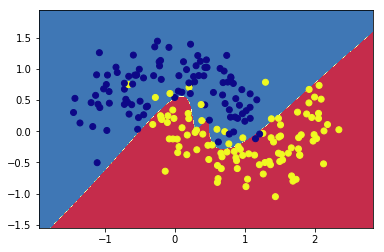

In [29]:
model = Neural_Net(NN_size=[2, 10, 6, 2], actFun_type='tanh')
mean, loss = model.fit_model(X, t, 0.001)
model.visualize_decision_boundary(X, y)

#### (2) 5 Layers, 3 hidden layers: each of hidden layers has 6 neurons

Loss after iteration 0: 381.965875
Loss after iteration 200: 60.219004
Loss after iteration 400: 80.134928
Loss after iteration 600: 81.868695
Loss after iteration 800: 83.966461
Loss after iteration 1000: 84.157107
Loss after iteration 1200: 82.294894
Loss after iteration 1400: 79.044746
Loss after iteration 1600: 69.505596
Loss after iteration 1800: 68.377433
Loss after iteration 2000: 67.612005
Loss after iteration 2200: 69.047420
Loss after iteration 2400: 89.367005
Loss after iteration 2600: 98.744004
Loss after iteration 2800: 94.888272
Loss after iteration 3000: 84.848216
Loss after iteration 3200: 83.624555
Loss after iteration 3400: 83.263195
Loss after iteration 3600: 84.823984
Loss after iteration 3800: 82.688638


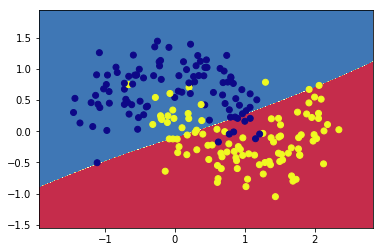

In [30]:
model = Neural_Net(NN_size=[2, 6, 6, 6, 2], actFun_type='tanh')
mean, loss = model.fit_model(X, t, 0.001)
model.visualize_decision_boundary(X, y)

-----

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

/Users/dongchenghe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
X = mnist.train.images
t = mnist.train.labels
X_test=mnist.test.images
t_test=mnist.test.labels

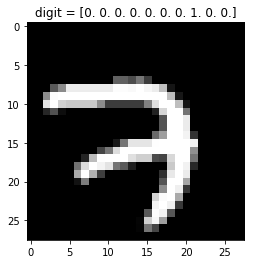

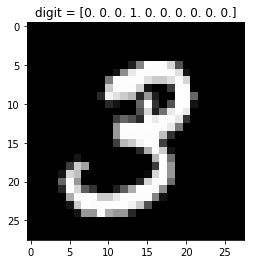

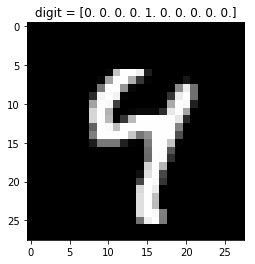

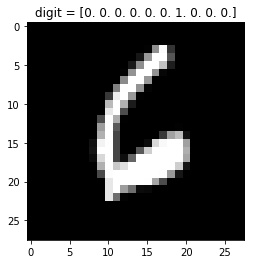

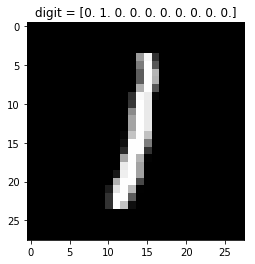

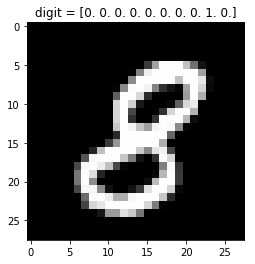

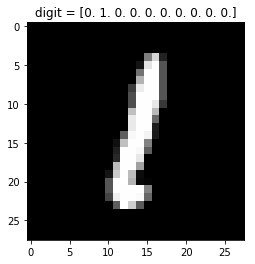

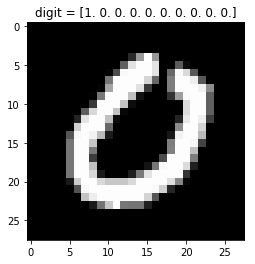

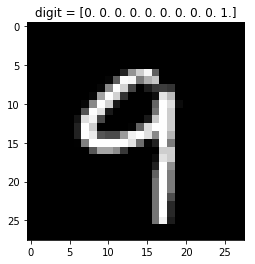

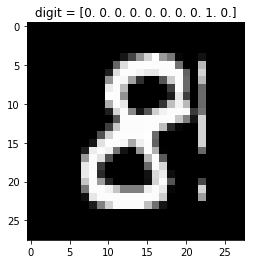

In [5]:
for idx in range(10):
    plt.imshow(np.reshape(X[idx,:], (28,28)),cmap= 'gray' )
    plt.title('digit = {}'.format(str(t[idx])))
    plt.show()

In [45]:
class Neural_Net(object):
    
    def __init__(self, NN_size, actFun_type, reg_lambda=0.000000001, seed=10):
        
        self.layers=len(NN_size)
        self.sizes=NN_size
        
        
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda

        self.losses = []
        self.out=[]

        
        np.random.seed(seed)
        self.W=[np.random.randn(x,y) for x, y in zip(self.sizes[:-1], 
                                                     self.sizes[1:])]
        self.b=[np.random.randn(y) for y in self.sizes[1:]]



    def actFun(self, a, non_Linearity):
        '''
        actFun computes the activation functions
        :param a = net input
        :param non_Linearity = Tanh, Sigmoid, or ReLU
        :return: net activation
        '''
        
        if non_Linearity == 'tanh':
            out = (np.exp(a)-np.exp(-a)) / (np.exp(a)+np.exp(-a))
        elif non_Linearity == 'sigmoid':
            out = 1 / (1 + np.exp(-a))
        elif non_Linearity == 'relu':
            out=(a+np.abs(a))/2
        else:
            print("Only three types of activation functions: tanh, sigmoid, and relu. Please try again")
        
        return np.nan_to_num(out)

        
    def diff_actFun(self, a, non_Linearity):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param a= net input
        :param non_Linearity = Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''
        
        if non_Linearity == 'tanh':
            out = 4*np.exp(2*a) / np.square(1 + np.exp(2*a))
        elif non_Linearity == 'sigmoid':
            out = np.exp(-a) / np.square(1 + np.exp(-a))
        elif non_Linearity == 'relu':
            out = 1. * (a > 0)
        else:
            print("Only three types of activation functions: tanh, sigmoid, and relu. Please try again")
        
        return np.nan_to_num(out)
        
        
    def softmax(self, z):

        exp_sum = np.sum(np.exp(z), 1)
        t = np.tile(exp_sum, [self.sizes[self.layers-1], 1]).T
        out = np.exp(z)* (1 / t)

        return out

    def ForwardPass(self, X, actFun):
        
        self.out.append(X)
        for w, b in zip(self.W[:-1], self.b[:-1]):
            X=actFun(np.dot(X,w)+b.T)
            self.out.append(X)

        
        X= np.dot(X,self.W[self.layers-2])+self.b[self.layers-2].T
        self.probs = self.softmax(X)

        return None

    def calculate_loss(self, t):
        
        self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
        a = np.nan_to_num(np.log(self.probs))
        data_loss=np.mean(-np.sum(a*t))
        self.out=[]

        return data_loss   
    
    
    def calculate_precision(self, t):
        
        self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
        a = np.argmax(self.probs, axis=1)
        b = np.argmax(t, axis=1)
        c = a-b
        c[c!=0]=1
        precision = 1-np.sum(np.abs(c))/len(t)
        self.out=[]

        return precision  
        

    def predict(self, X):
        
        self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))
        self.out=[]
        return np.argmax(self.probs, axis=1)

    def backwardPass(self, X, t):
        
        out = self.out
        
        delta_scores = (self.probs - t)
        dW=[np.zeros((x,y)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.out=[]
        self.ForwardPass(X, lambda x: self.diff_actFun(x, self.actFun_type))
        
        delta = [np.zeros((200, y)) for y in self.sizes]
        
        delta[self.layers-1]=delta_scores
        
        for i in range(self.layers-1):
            delta[self.layers-2-i]=np.dot(delta[self.layers-1-i],self.W[self.layers-2-i].T)*self.out[self.layers-2-i]
        
        for j in range(self.layers-1):
            dW[j]=np.dot(out[j].T, delta[j+1])
            delta[j+1]=np.mean(delta[j+1], axis=0)
        
        db = delta[1:]
        
        self.out=[]
        return dW, db

      
    def fit_model(self, X, t, epsilon, num_passes=1000, print_loss=True):
        for i in range(0, num_passes):
            self.ForwardPass(X, lambda x: self.actFun(x, self.actFun_type))

            dW, db = self.backwardPass(X, t)

            if i<400:
                lbd=100*self.reg_lambda
            elif i<1000:
                lbd=0.1*self.reg_lambda
            elif i<1500:
                lbd = 0.0001*self.reg_lambda
            else: 
                lbd = 0.00001*self.reg_lambda

            for j in range(self.layers-1):
                dW[j] += lbd * self.W[j]
                self.W[j] += -epsilon * dW[j]
                self.b[j] += -epsilon * db[j]

            if print_loss and i % 100 == 0:
                print("Precision after iteration %i: %f" % (i, self.calculate_precision(t)))
                result = self.calculate_loss(t)
                self.losses.append(result)
            mean=np.mean(self.losses)
        return mean, self.losses
    
    
    def visualize_decision_boundary(self, X, y):
        plot_decision_boundary(lambda x: self.predict(x), X, y)

In [46]:
# Because it is a 784-feature dataset of "0 to 9" 10 numbers, so the NN_size is [784, 20, 10]
model = Neural_Net(NN_size=[784, 20, 10], actFun_type='sigmoid')
mean, loss = model.fit_model(X, t, 0.0001)

Precision after iteration 0: 0.124145
Precision after iteration 100: 0.846600
Precision after iteration 200: 0.885709
Precision after iteration 300: 0.902164
Precision after iteration 400: 0.911327
Precision after iteration 500: 0.916818
Precision after iteration 600: 0.921273
Precision after iteration 700: 0.926109
Precision after iteration 800: 0.929582
Precision after iteration 900: 0.932291
